In [34]:
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import os
import glob
import skimage.io

from PIL import Image

In [2]:
from labelMaker import labelMaker

In [84]:
def get_coords_from_path(path):
    names = path.split('/')
    coords = names[-1].split('_')
    
    return int(coords[1]), int(coords[2])

In [101]:
def build_dataset_for_puzzle(pieces_path, image_dims):
    
    all_images = []
    # maybe need * in puzzle pieces path
    for f in glob.iglob(pieces_path):
        print(f)
        if not os.path.isdir(f):
            
            # im = skimage.io.imread(f)
            # im = Image.open(f)
            x, y = get_coords_from_path(f)
            
            im = loadPiece(x, y, image_dims[0], image_dims[1], pieces_path[:-2])

            all_images.append([  im, (x,y)  ])
        
    
    N = len(all_images)**2 - len(all_images)
    X = np.empty(  (N, image_dims[0], image_dims[1], 6)  )
    y = np.empty((N, 5))
    
    idx = 0
    for i in range(len(all_images)):
        
        for j in range(len(all_images)):
            
            if i != j:
                
                X[idx] = np.reshape(np.concatenate((all_images[i][0], all_images[j][0])),  (image_dims[0], image_dims[1], 6))
                y[idx] = np.squeeze(np.array(
                    labelMaker(
                              all_images[i][1][0],
                              all_images[i][1][1],
                              all_images[j][1][0],
                              all_images[j][1][1])))
                idx += 1
                
    
    return X, y
        
        
    

In [136]:
(1000, *X.shape)

(1000, 600, 200, 200, 6)

In [137]:
# direc : directory which contains several puzzle piece directories

def build_full_dataset(direc, piece_size=(200,200)):
    
    X_list = []
    y_list = []
    for d in glob.iglob(direc):
        d = d + '/*'
        
        X, y = build_dataset_for_puzzle(d, piece_size) 
        X_list.append(X)
        y_list.append(y)
    
    
    full_X = np.empty((len(X_list), *X_list[0].shape))
    print('DEBUG: '+ full_X.shape)
    full_y = np.empty((len(y_list)))
    
    for i in range(len(X_list)):
        full_X[i] = X_list[i]
        full_y[i] = y_list[i]
        
    
    return full_X, full_y
        
        


In [102]:
# loads a piece
def loadPiece(xpos, ypos, xpixels, ypixels, directory):
    filename = '{}/piece_{}_{}'.format(directory, xpos, ypos)
    new_data = np.loadtxt(filename)
    #print(filename)

    # look at the name of the folder and reshape to (__, __, 3) for back to rgb
    new_data = new_data.reshape(xpixels,ypixels,3)
    
    return new_data

In [103]:
test_path = '/Users/maxperozek/ML-CP341/jigsaw/images0to2/image_2/*'

In [104]:
## test
X, y = build_dataset_for_puzzle(test_path, (200,200))


/Users/maxperozek/ML-CP341/jigsaw/images0to2/image_2/piece_4_4
/Users/maxperozek/ML-CP341/jigsaw/images0to2/image_2/piece_4_3
/Users/maxperozek/ML-CP341/jigsaw/images0to2/image_2/piece_2_1
/Users/maxperozek/ML-CP341/jigsaw/images0to2/image_2/piece_0_2
/Users/maxperozek/ML-CP341/jigsaw/images0to2/image_2/piece_4_2
/Users/maxperozek/ML-CP341/jigsaw/images0to2/image_2/piece_0_4
/Users/maxperozek/ML-CP341/jigsaw/images0to2/image_2/piece_0_3
/Users/maxperozek/ML-CP341/jigsaw/images0to2/image_2/piece_2_0
/Users/maxperozek/ML-CP341/jigsaw/images0to2/image_2/piece_1_1
/Users/maxperozek/ML-CP341/jigsaw/images0to2/image_2/piece_3_2
/Users/maxperozek/ML-CP341/jigsaw/images0to2/image_2/piece_3_4
/Users/maxperozek/ML-CP341/jigsaw/images0to2/image_2/piece_3_3
/Users/maxperozek/ML-CP341/jigsaw/images0to2/image_2/piece_1_0
/Users/maxperozek/ML-CP341/jigsaw/images0to2/image_2/piece_2_2
/Users/maxperozek/ML-CP341/jigsaw/images0to2/image_2/piece_0_1
/Users/maxperozek/ML-CP341/jigsaw/images0to2/image_2/pi

In [106]:
X.shape

(600, 200, 200, 6)

In [108]:
y.shape

(600, 5)

### Simple Model Playground

In [132]:
y

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

In [109]:
def build_CNN_w_pooling(X):    
    model = Sequential()

    model.add(Conv2D(32,(3,3),input_shape=X.shape[1:] ,activation = 'relu',padding='same',))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [111]:
model = build_CNN_w_pooling(X)

2022-05-15 21:27:15.197878: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [112]:
model.fit(X, y , epochs=30, batch_size=32, validation_split=0.1)

Epoch 1/30
17/17 [==============================] - 24s 1s/step - loss: 120.6463 - accuracy: 0.7481 - val_loss: 1.0253 - val_accuracy: 0.8500
Epoch 2/30
17/17 [==============================] - 24s 1s/step - loss: 0.7394 - accuracy: 0.8593 - val_loss: 1.1452 - val_accuracy: 0.8500
Epoch 3/30
17/17 [==============================] - 22s 1s/step - loss: 0.7084 - accuracy: 0.8685 - val_loss: 1.1197 - val_accuracy: 0.8500
Epoch 4/30
17/17 [==============================] - 22s 1s/step - loss: 0.6860 - accuracy: 0.8685 - val_loss: 0.7028 - val_accuracy: 0.8500
Epoch 5/30
17/17 [==============================] - 23s 1s/step - loss: 0.6620 - accuracy: 0.8685 - val_loss: 0.6723 - val_accuracy: 0.8500
Epoch 6/30
17/17 [==============================] - 24s 1s/step - loss: 0.6649 - accuracy: 0.8685 - val_loss: 0.8269 - val_accuracy: 0.8500
Epoch 7/30
17/17 [==============================] - 24s 1s/step - loss: 0.6653 - accuracy: 0.8685 - val_loss: 0.6992 - val_accuracy: 0.8500
Epoch 8/30


KeyboardInterrupt: 

In [113]:
model.predict(X)

array([[0.12516342, 0.10846931, 0.11553416, 0.10564344, 0.5451897 ],
       [0.09151299, 0.07960231, 0.07611708, 0.07968806, 0.67307955],
       [0.08452865, 0.06726538, 0.05977225, 0.06250986, 0.7259239 ],
       ...,
       [0.10909431, 0.10055214, 0.1113238 , 0.11079023, 0.5682395 ],
       [0.09062684, 0.08424608, 0.08398275, 0.09016786, 0.6509765 ],
       [0.10043259, 0.09283187, 0.09430876, 0.10005014, 0.6123767 ]],
      dtype=float32)

In [114]:
import matplotlib.pyplot as plt

In [120]:
X[0,:,:,:3].shape

(200, 200, 3)

In [142]:
X[0,:,:,:3]

array([[[ 96.,  89.,  63.],
        [121., 114.,  88.],
        [139., 132., 104.],
        ...,
        [185.,  66.,  36.],
        [178.,  65.,  36.],
        [171.,  63.,  31.]],

       [[ 99.,  92.,  66.],
        [115., 107.,  81.],
        [132., 123.,  96.],
        ...,
        [186.,  66.,  32.],
        [179.,  66.,  32.],
        [173.,  62.,  28.]],

       [[112., 102.,  77.],
        [116., 104.,  78.],
        [127., 116.,  88.],
        ...,
        [186.,  64.,  27.],
        [182.,  65.,  28.],
        [177.,  64.,  26.]],

       ...,

       [[ 40.,  47.,  39.],
        [ 40.,  47.,  39.],
        [ 38.,  45.,  37.],
        ...,
        [ 58.,  61.,  54.],
        [ 59.,  62.,  55.],
        [ 59.,  61.,  56.]],

       [[ 42.,  49.,  41.],
        [ 43.,  50.,  42.],
        [ 40.,  47.,  39.],
        ...,
        [ 51.,  52.,  46.],
        [ 53.,  56.,  49.],
        [ 54.,  56.,  51.]],

       [[ 42.,  49.,  41.],
        [ 42.,  49.,  41.],
        [ 40.,  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


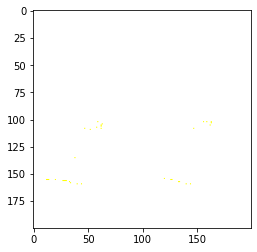

In [141]:
plt.imshow(X[4,:,:,3:])